In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/')

Mounted at /content/drive


In [595]:
import Data_generator_multiple as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import math, random
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [596]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed = 36
num_stocks = 2
npaths = 100000
seq_length = 240
T=10
s0=np.array([1,1])
mu = np.array([0.12, 0.12])
#mu = np.array([0.0362, 0.0036])
k = 0.075
cov = np.array([[0.4-k, k],[k, 0.4-k]])
#cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
trade_cost = [0.01,0.01]
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 100
learning_rate = 0.01
initial_rotate_matrix = torch.tensor([[1.1,-0.1], [-0.1,1.1]])

In [597]:
# set up the trading costs
all_cost = np.ones([num_stocks,seq_length-1,npaths])
for i in range(num_stocks):
  all_cost[i,:,:] = trade_cost[i]

# calculate rho: Notice the single is used only for plotting a 2 asset situation
if (num_stocks==2):
    rho = np.round(cov[0,1]/(np.sqrt(cov[0,0]*cov[1,1])),3)

In [598]:
# To determine optimal trading frequency, based on Johannes Muhle-Karbe's paper, higher dimension waited to be verified
# step 1: Calculting the Markowitz optimal
Markowitz_opt = np.matmul(np.linalg.inv(cov),mu)/utility_gamma
Markowitz_opt_tensor =  torch.tensor(Markowitz_opt,dtype = torch.float).to(device)
# step 2: Define the distance for initial non trade region
delta = 0.01*np.power(np.diag(cov)*trade_cost/utility_gamma,1/3)
delta_tensor = torch.tensor(delta, dtype = torch.float).to(device)

In [599]:
# Pre-process some data for the corner of the no trade region
cc= np.ones([4,2,2])
cc[0,:,:] = np.array([[-1,0],[0,-1]])
cc[1,:,:] = np.array([[-1,0],[0,1]])
cc[2,:,:] = np.array([[1,0],[0,1]])
cc[3,:,:] = np.array([[1,0],[0,-1]])
index_matrix = torch.tensor(cc,dtype = torch.float).to(device)

In [600]:
# Create a stock simulation with prices, returns
stock = dg.ManyStocks(seed,num_stocks,mu,s0,cov,npaths,seq_length-1,T)
returns = torch.tensor(stock.Returns(),dtype=torch.float).to(device)
# Create a default strategy as initial input, better use the optimal strategy without cost
strategy = (torch.tensor(Markowitz_opt,dtype=torch.float).view(num_stocks,1,1)*torch.ones((num_stocks,seq_length,npaths),dtype=torch.float)).to(device)
# Create a trading cost
cost =  torch.tensor(all_cost,dtype=torch.double).to(device)

In [601]:
# Calculate return of specific strategy
def cal_return(strat):   
    r0 = torch.sum(strat[:,:-1, :]*returns,0)
    r1 = r0-torch.sum(cost*abs((r0+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r2 = r0-torch.sum(cost*abs((r1+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r3 = r0-torch.sum(cost*abs((r2+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r4 = r0-torch.sum(cost*abs((r3+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r5 = r0-torch.sum(cost*abs((r4+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    return r5

class Cal_return(nn.Module):
    def __init__(self):
        
        super().__init__()

    def forward(self, strat):

        return cal_return(strat) 

In [602]:
# Define a log utility function
class LogUtilityLoss(torch.nn.Module):
    
    def __init__(self):
        super(LogUtilityLoss,self).__init__()
        
    def forward(self,x):
        loss = -torch.mean(torch.log(x))
        return loss

# Define a power utility function
class PowerUtilityLoss(torch.nn.Module):
    
    def __init__(self,gamma):
        super(PowerUtilityLoss,self).__init__()
        self.gamma = gamma
        
    def forward(self,x):
        loss = -torch.mean((torch.pow(x,1-self.gamma)-1)/(1-self.gamma))
        return loss

In [603]:
# Customize a RNN layer with double relu for multiple assets
# considering returns data to build a changed strategy weight according to price change
class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, batch_size,dim_size):
        """Initialize params."""
        super(MyRNN, self).__init__()
        # read input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dim_size = dim_size

        # Define parameters of double relu function for activation function
        self.input_param = nn.Linear(input_size, dim_size,  hidden_size).to(device)
        self.hidden_param = nn.Linear(hidden_size,  dim_size, hidden_size).to(device)
        self.fc1_param = nn.Linear(hidden_size, dim_size,hidden_size).to(device)
        self.fc2_param = nn.Linear(hidden_size, dim_size, hidden_size).to(device)
        self.rotate_param = nn.Linear(dim_size,dim_size,bias=False)
                
    # Forward function allows a form:
    # h_t = w_fc2*relu(w_fc1*relu(w_inp*x_t+b_inp+w_h*h_{t-1}+b_h)+b_fc1)+b_fc2+b_fc1-b_h1
    def forward(self, input, hidden):
        def myrotate(input_rotate):
            input_new = input_rotate.squeeze(1)
            out = torch.matmul(self.rotate_param.weight,input_new)
            return out.unsqueeze(1)

        # a function that creates the corner of the rotated no trade region
        def corner():
            res = (torch.matmul(index_matrix,self.hidden_param.bias)).T
            res = torch.matmul(self.rotate_param.weight,res).T+Markowitz_opt_tensor
            return res

        # Create the corner and related slope of different lines
        Corner = corner()
        ac = self.rotate_param.weight[1,0]/self.rotate_param.weight[0,0]
        bd = self.rotate_param.weight[0,1]/self.rotate_param.weight[1,1]
        

        def lower_bound_x(x):
            ingate = (x.squeeze(1)[1]-Corner[0,1]*(bd>=0)-Corner[1,1]*(bd<0))*bd

            ingate2 = -F.relu(ingate)+torch.abs(Corner[1,0]-Corner[0,0])

            res = -F.relu(ingate2)+Corner[1,0]*(bd>=0)+Corner[0,0]*(bd<0)
            return res

        def upper_bound_x(x):
            ingate = (x.squeeze(1)[1]-Corner[3,1]*(bd>=0)-Corner[2,1]*(bd<0))*bd

            ingate2 = -F.relu(ingate)+torch.abs(Corner[2,0]-Corner[3,0])

            res = -F.relu(ingate2)+Corner[2,0]*(bd>=0)+Corner[3,0]*(bd<0)
            return res

        def lower_bound_y(x):
            ingate = (x.squeeze(1)[0]-Corner[0,0]*(ac>=0)-Corner[3,0]*(ac<0))*ac

            ingate2 = -F.relu(ingate)+torch.abs(Corner[0,1]-Corner[3,1])

            res = -F.relu(ingate2)+Corner[3,1]*(ac>=0)+Corner[0,1]*(ac<0)
            return res

        def upper_bound_y(x):
            ingate = (x.squeeze(1)[0]-Corner[1,0]*(ac>=0)-Corner[2,0]*(ac<0))*ac

            ingate2 = -F.relu(ingate)+torch.abs(Corner[1,1]-Corner[2,1])

            res = -F.relu(ingate2)+Corner[2,1]*(ac>=0)+Corner[1,1]*(ac<0)
            return res

        def lower_bound(x):
            return torch.stack((lower_bound_x(x),lower_bound_y(x))).view(self.dim_size,self.hidden_size,self.batch_size)

        def upper_bound(x):
            return torch.stack((upper_bound_x(x),upper_bound_y(x))).view(self.dim_size,self.hidden_size,self.batch_size)

        def recurrence(input, hidden):
            # w_inp*x_t+b_inp+w_h*h_{t-1}+b_h
            ingate = self.input_param.weight.view(self.dim_size,self.input_size,self.hidden_size)*input \
                    + self.hidden_param.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*hidden - lower_bound(hidden)
            # w_fc1*relu(ingate)+upper-lower
            ingate2 = self.fc1_param.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*F.relu(ingate)\
                    + upper_bound(hidden) - lower_bound(hidden)
            # w_fc2*relu(ingate2)+upper
            h       = self.fc2_param.weight.view(self.dim_size,self.hidden_size,self.hidden_size)*F.relu(ingate2) + upper_bound(hidden)
            return h

        output = []
        steps = range(input.size(1))
        myret = returns
        for i in steps:
            if i ==0:
                hidden = input[:,0,:].view(self.dim_size,1,self.batch_size).to(device)
                #hidden = (torch.tensor(Markowitz_opt,dtype=torch.float).view(self.dim_size,1,1)*torch.ones((self.dim_size,1,self.batch_size),dtype=torch.float)).to(device)
            else:
                # pi_t = myrotate(pi_{t-1}*(1+r_t)/(1+sum(pi_{t-1}*r_t))) due to change of price after rebalance
                adjust_pi = hidden.view(self.dim_size,1,self.batch_size)*(1+myret[:,i-1,:].view(self.dim_size,1,self.batch_size))\
                                    /(1+torch.sum(hidden.view(self.dim_size,1,self.batch_size)*myret[:,i-1,:].view(self.dim_size,1,\
                                    self.batch_size),0))
                                    
                           

                hidden = recurrence(input[:,i,:].view(self.dim_size,self.input_size,self.batch_size), adjust_pi)
            
            output.append(hidden)

        output = torch.cat(output, 1)

        return output, hidden

In [604]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size, seq_length, dim_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.dim_size = dim_size
        # the rnn layer which works as out, hidden_t = f(out_(t), hidden_(t-1)), used to approximate pi^*_(t)= f(pi^*_(t-1),pi_t)
        self.rnn = MyRNN(input_size, hidden_size, batch_size, dim_size).to(device)
        self.out = nn.Linear(dim_size, hidden_size,bias=False).to(device)
        # initialize some bias and weight
        self.rnn.input_param.weight = torch.nn.Parameter(torch.zeros_like(self.rnn.input_param.weight))
        self.rnn.hidden_param.weight = torch.nn.Parameter(torch.ones_like(self.rnn.hidden_param.weight))
        self.rnn.hidden_param.bias = torch.nn.Parameter(delta_tensor)
        self.rnn.fc1_param.bias = torch.nn.Parameter(2*delta_tensor)
        self.rnn.fc1_param.weight = torch.nn.Parameter(-1*torch.ones_like(self.rnn.fc1_param.weight))
        self.rnn.fc2_param.weight = torch.nn.Parameter(-1*torch.ones_like(self.rnn.fc2_param.weight))
        self.rnn.rotate_param.weight = torch.nn.Parameter(initial_rotate_matrix)
        self.out.weight = torch.nn.Parameter(*torch.ones_like(self.out.weight))
    

    def step(self, input, hidden=None):
        output, hidden = self.rnn(input, hidden).to(device)
        output2 = self.out.weight.view(dim_size,hidden_size,hidden_size)*output
        return output, output2

    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden().to(device)
        output, hidden = self.rnn(inputs.float(), hidden.float())
        # output2 the overall wealth at time T
        output2 = torch.prod(cal_return(output).to(device)+1,0)
        return  output, output2
        #return  output
        
    def __init__hidden(self):
        hidden = 0.0*torch.ones(self.dim_size, self.hidden_size,  self.batch_size,dtype=torch.float64).to(device)
        return hidden

In [605]:
input_size = 1
hidden_size = 1
n_layers = 1
batch_size = npaths
seq_length = seq_length
dim_size = num_stocks

model = SimpleRNN(input_size, hidden_size, n_layers, batch_size, seq_length,dim_size).to(device)
#criterion = LogUtilityLoss()
criterion = PowerUtilityLoss(utility_gamma)
model.out.weight.requires_grad = False
model.rnn.input_param.weight.requires_grad = False
model.rnn.hidden_param.weight.requires_grad = False
model.rnn.fc1_param.weight.requires_grad = False
model.rnn.fc2_param.weight.requires_grad = False
model.rnn.fc1_param.bias.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=1)



In [606]:
losses = np.zeros(n_epochs+1) 

for epoch in range(n_epochs+1):
    inputs = strategy.to(device)
    fina_strat, outputs = model(inputs.double(), None)

    loss = criterion(outputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #scheduler.step()

    losses[epoch] += loss
    if epoch % 10 == 0:
        print(epoch, loss)
        print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))


0 tensor(-0.1244, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-0 lr: 0.01
10 tensor(-0.1526, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-10 lr: 0.01
20 tensor(-0.1530, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-20 lr: 0.01
30 tensor(-0.1543, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-30 lr: 0.01
40 tensor(-0.1542, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-40 lr: 0.01
50 tensor(-0.1543, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-50 lr: 0.01
60 tensor(-0.1544, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-60 lr: 0.01
70 tensor(-0.1544, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-70 lr: 0.01
80 tensor(-0.1544, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-80 lr: 0.01
90 tensor(-0.1544, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Epoch-90 lr: 0.01
100 tensor(-

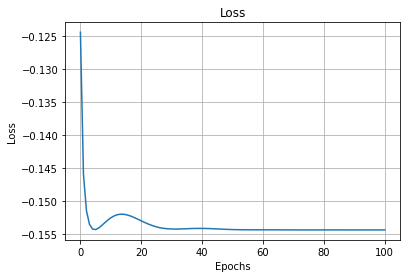

In [607]:
# Plot loss curve
epochs = range(n_epochs+1)

fig, ax = plt.subplots()
ax.plot(epochs, losses)

ax.set(xlabel='Epochs', ylabel='Loss',
       title='Loss')
ax.grid()
from google.colab import files
#fig.savefig("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov)), format='png', dpi=500)
#files.download("loss_correl{}_mu{}_sigma{}.png".format(rho,mu,np.diag(cov))) 

plt.show()


In [608]:
# output the weights and bias of the model parameter
for name, param in model.named_parameters():
     print (name, param.data)

rnn.input_param.weight tensor([[0.],
        [0.]], device='cuda:0')
rnn.input_param.bias tensor([-0.2653, -0.6433], device='cuda:0')
rnn.hidden_param.weight tensor([[1.],
        [1.]], device='cuda:0')
rnn.hidden_param.bias tensor([0.0427, 0.0431], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.],
        [-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([0.0024, 0.0024], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.],
        [-1.]], device='cuda:0')
rnn.fc2_param.bias tensor([0.2554, 0.9132], device='cuda:0')
rnn.rotate_param.weight tensor([[ 0.9767, -0.1400],
        [-0.1885,  0.9774]], device='cuda:0')
out.weight tensor([1., 1.], device='cuda:0')


In [609]:
# figure out the a and b of each relu boundary
a1=Markowitz_opt[0]-model.rnn.hidden_param.bias[0].cpu().detach().numpy()
b1=Markowitz_opt[0]+model.rnn.hidden_param.bias[0].cpu().detach().numpy()
a2=Markowitz_opt[1]-model.rnn.hidden_param.bias[1].cpu().detach().numpy()
b2=Markowitz_opt[1]+model.rnn.hidden_param.bias[1].cpu().detach().numpy()
centre = Markowitz_opt.reshape(num_stocks,1)
# Define the boundary matrix to plot
x = np.array([a1,b1,a1,b1])
y = np.array([a2,a2,b2,b2])
c = model.rnn.rotate_param.weight.cpu().detach().numpy()
xy = np.array([x,y])
xy2 = np.dot(c,xy-centre)+centre
xy3 = np.delete(xy2,1,1)
xy4 = np.delete(xy2,2,1)

In [610]:
# Plot the actual boundary of adjusted non-trade region of certain covriance matrix
# plt.figure(figsize=(6,5))
# plt.plot(xy3[0,:], xy3[1,:],color="blue")
# plt.plot(xy4[0,:], xy4[1,:],color="blue")
# plt.xlim((0.05,0.25))
# plt.ylim((0.05,0.25))
# plt.xticks(np.arange(0.05,0.25,0.05))
# plt.yticks(np.arange(0.05,0.25,0.05))
# plt.grid()
# plt.title(label='No trade Region(\u03C1={})'.format(rho))
# plt.title(label='Example: No trade Region')
# from google.colab import files
# plt.savefig("correl{}_mu{}_sigmasquare{}.png".format(rho,mu,np.diag(cov)), format='png', dpi=500)
# files.download("correl{}_mu{}_sigmasquare{}.png".format(rho,mu,np.diag(cov)))
# plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

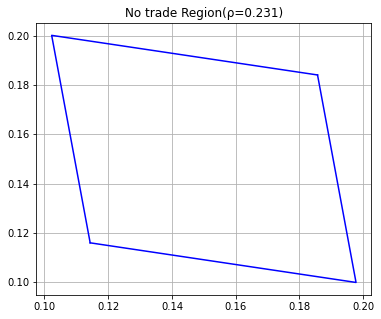

In [611]:
# Plot the actual boundary of adjusted non-trade region of certain covriance matrix
plt.figure(figsize=(6,5))
plt.plot(xy3[0,:], xy3[1,:],color="blue")
plt.plot(xy4[0,:], xy4[1,:],color="blue")
plt.grid()
plt.title(label='No trade Region(\u03C1={})'.format(rho))
#plt.title(label='Example: No trade Region')
from google.colab import files
plt.savefig("correl{}_mu{}_sigmasquare{}.png".format(rho,mu,np.diag(cov)), format='png', dpi=500)
files.download("correl{}_mu{}_sigmasquare{}.png".format(rho,mu,np.diag(cov)))
plt.show()

In [612]:
# Comparison between different ESR, notice this is specially defined for the liquid and illiquid case
# Calculate the simulated ESR
ESR_Simulation = torch.log(torch.pow(torch.mean(torch.pow(outputs,1-utility_gamma)),1/(1-utility_gamma)))/T
# Calculate the theoretical ESR
sigma_I = np.sqrt(cov[1,1]*(1-rho*rho))
beta2 = np.sqrt(cov[1,1]*rho*rho/cov[0,0])
alpha = mu[1]-beta2*mu[0]
Inside = np.power(beta2-mu[0]/utility_gamma/cov[0,0],2)*cov[0,0]+np.power((1-Markowitz_opt[1])*sigma_I,2)
ESR_Theo =1/2/utility_gamma*(mu[0]*mu[0]/cov[0,0]+alpha*alpha/sigma_I/sigma_I)-\
      np.power(3*Markowitz_opt[1]*Markowitz_opt[1]*sigma_I/8/np.sqrt(2*utility_gamma)*Inside*trade_cost[1],2/3)
print(ESR_Theo)
print(ESR_Simulation.cpu().detach().numpy())

0.01769579304722773
0.016771470207613663


In [613]:
# Calculate the Confidence Interval of ESR
interval = 1.96*torch.std(torch.pow(outputs,1-utility_gamma))/np.sqrt(npaths)
CI_upper = torch.log(torch.pow(torch.mean(torch.pow(outputs,1-utility_gamma))-interval,1/(1-utility_gamma)))/T
CI_lower = torch.log(torch.pow(torch.mean(torch.pow(outputs,1-utility_gamma))+interval,1/(1-utility_gamma)))/T
print(CI_lower.cpu().detach().numpy())
print(CI_upper.cpu().detach().numpy())

0.016507697826062935
0.01703594018833658
